**Motivation: Why did I choose this application?**

* I wanted to work on something that I have never worked on before, but also choose based on my interest.

* I have always been fasinated by the stock market, and eager to learn about it. I am not familiar with all the ins and outs related to stock market but I believe this will be a good starting point if I ever wanted to start learning about it.  

* My belief is that stock market is no different than gambling, no one knows what will happen to a organization or an industry in future, people just bet based on their instints baised-on/driven-by what they have exprienced before. 

* Hence by taking on the project, I want to know if my beliefs are correct or not. If by combining the analytical model results, along with expreience can we better guess the outcome of the stock ?

**Goals: What are the goals of the application?**
    
The goal of the project is to train a model on the available data and then try to predict whether we will lose money or gain money 3 months in the future. Hence I have considered this as a classification problem where an ***event*** be if a person would make money 3 months from the day he invested in the company.

Tried out different combination for training the models.  

1 - Generalized Linear Models
* Models trained solely on 2020, 2021, and 2022 wtih PCA data respectively
* Model trained on all 3 years of data with PCA
* Models trained on trend and seasonal values extracted from Time Series Decomposition in combination with PCA
* Models trained by performinf interactions on trend and seasonal values

2 - Advanced Non-Linear Models
* Neural Netwrok
* Support Vector Machine (SVM)
* Random Forest
* Gradient Boosted Trees

**Major Findings**
* It's quite hard to predict 2020 data.

* Even though the closing prices of the stocks with the data we have used were all over the palce as the data included pandemic period (2020 data), a recession period with tech companies booming and busting in the period between 2020-2022, our best model provided us with a accuracy on hold-out test set of about 72% which is in my thought quite surprising and way better than just a random guess.

* We are able to group out utilities sector 

**Skills Learned**

* The one thing I will definately take away from this project is ***data wrangling*** skills. Had to go through lot of manipulation by groupuing, aggregating, restructuing the data in order to make data ready answering different questions.

* **PCA**. Even though I learned it in last semester but it was near the end of the semester so was not quite sure of it. But after learning it again and applying those concepts in this project I feel much more confident about what PCA is and how it can help.

**References and resources:**

* The data contains the closing prices of all S&P500 companies.

* Learned how to obtain the data from S&P500 data example from machine learning class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

### Reading the Data 

In [2]:
stock_lf = pd.read_csv('sp500_stock_20_22_close_with_sector_long_format.csv')

In [3]:
stock_wf = pd.read_csv('sp500_stock_20_22_close_with_sector_wide_format.csv')

In [4]:
stock_lf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378000 entries, 0 to 377999
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   symbol      378000 non-null  object 
 1   close       378000 non-null  float64
 2   date        378000 non-null  object 
 3   day_number  378000 non-null  object 
 4   sector      378000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 14.4+ MB


The companies are represent by the `symbol` column and the `sector` column represent the sector each company is in.

Adding a date column as `datetime` object.

In [5]:
stock_lf['date_dt'] = pd.to_datetime(stock_lf.date)

In [6]:
stock_lf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378000 entries, 0 to 377999
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   symbol      378000 non-null  object        
 1   close       378000 non-null  float64       
 2   date        378000 non-null  object        
 3   day_number  378000 non-null  object        
 4   sector      378000 non-null  object        
 5   date_dt     378000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 17.3+ MB


In [7]:
stock_lf.head()

,symbol,close,date,day_number,sector,date_dt
0,AAPL,75.087502,2020-01-02,day_001,Information Technology,2020-01-02
1,AAPL,74.357498,2020-01-03,day_002,Information Technology,2020-01-03
2,AAPL,74.949997,2020-01-06,day_003,Information Technology,2020-01-06
3,AAPL,74.597504,2020-01-07,day_004,Information Technology,2020-01-07
4,AAPL,75.797501,2020-01-08,day_005,Information Technology,2020-01-08


##### Checking number of rows and columns in dataset.

In [8]:
stock_lf.shape

(378000, 6)

##### Checking number of unique values.

In [9]:
stock_lf.nunique()

symbol          500
close         68644
date            756
day_number      756
sector           11
date_dt         756
dtype: int64

We have 500 different companies and the data spanning 3 years from 2020 to 2022

##### Unique values of `sector` and their frequency.

In [10]:
stock_lf.sector.nunique()

11

In [11]:
stock_lf.sector.value_counts()

Financials                56700
Industrials               53676
Information Technology    49896
Health Care               47628
Consumer Discretionary    40068
Consumer Staples          27972
Real Estate               22680
Materials                 21924
Utilities                 21924
Communication Services    18144
Energy                    17388
Name: sector, dtype: int64

There are 11 different sectors over which 500 companies are divided.

##### Checking number of missings.

In [12]:
stock_lf.isna().sum()

symbol        0
close         0
date          0
day_number    0
sector        0
date_dt       0
dtype: int64

There are no muissing values in the dataset.

##### Visualizing the closing prise over time

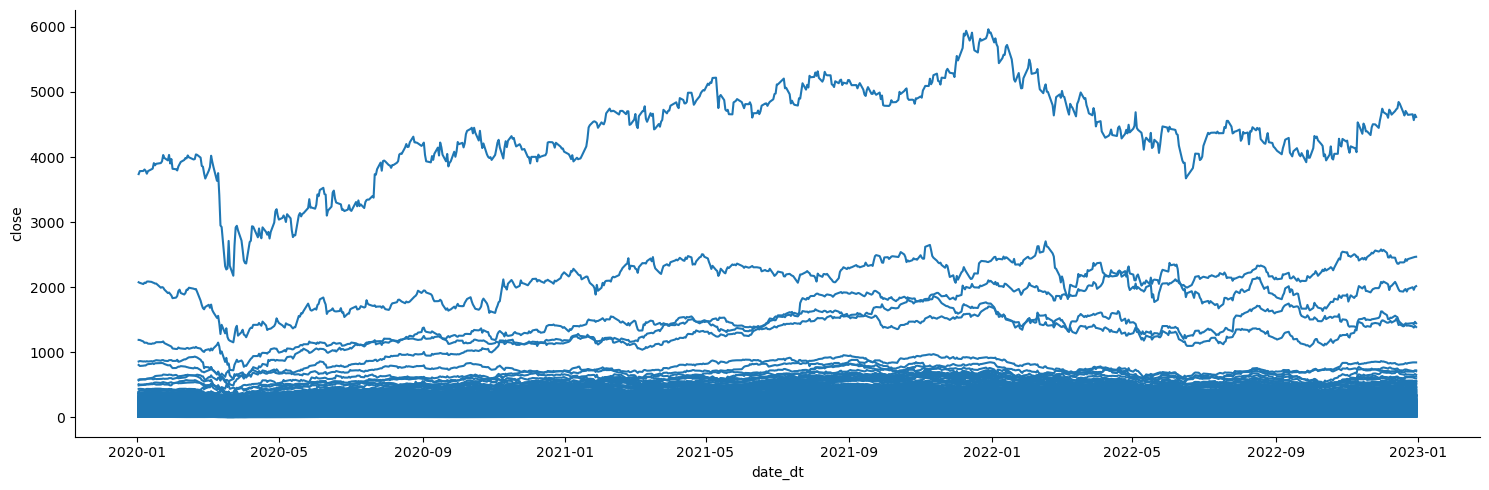

In [13]:
sns.relplot(data = stock_lf, x = 'date_dt', y = 'close', units = 'symbol', estimator = None, 
           kind = 'line', aspect = 3)

plt.show()

We can see the for few companies the range of closing price is quite high compared to most of the companies.

Instead of using the actual closing price of the stocks we will use the relative closing price.

Hence we will use the closing price of a stock on `Day-1` that is `2020-01-01` as the base and comapre all other days relative to that closing price.

We will calculate the relative closing price as follows:
$$ relative \ closing \ price = \frac{ \left(closing \ price - first \ closing \ price \right)}{first \ closing \ price} $$

##### Adding the relative closing price column.

Extraing the day-1 closing price of each company and adding it to the long  format dataframe

In [14]:
first_df =  stock_lf.groupby('symbol').\
            aggregate(min_date = ('date_dt', 'min'),
                      first_close = ('close', 'first')).\
            reset_index()

In [15]:
stock_lf = stock_lf.set_index('symbol').join(first_df.set_index('symbol'), on='symbol', how='left')

In [16]:
stock_lf = stock_lf.reset_index()

In [17]:
stock_lf.head()

,symbol,close,date,day_number,sector,date_dt,min_date,first_close
0,AAPL,75.087502,2020-01-02,day_001,Information Technology,2020-01-02,2020-01-02,75.087502
1,AAPL,74.357498,2020-01-03,day_002,Information Technology,2020-01-03,2020-01-02,75.087502
2,AAPL,74.949997,2020-01-06,day_003,Information Technology,2020-01-06,2020-01-02,75.087502
3,AAPL,74.597504,2020-01-07,day_004,Information Technology,2020-01-07,2020-01-02,75.087502
4,AAPL,75.797501,2020-01-08,day_005,Information Technology,2020-01-08,2020-01-02,75.087502


Adding the relative closing price column with the formula defined above.

In [18]:
stock_lf['rel_close'] = (stock_lf.close - stock_lf.first_close) / stock_lf.first_close

In [19]:
stock_lf

,symbol,close,date,day_number,sector,date_dt,min_date,first_close,rel_close
0,AAPL,75.087502,2020-01-02,day_001,Information Technology,2020-01-02,2020-01-02,75.087502,0.000000
1,AAPL,74.357498,2020-01-03,day_002,Information Technology,2020-01-03,2020-01-02,75.087502,-0.009722
2,AAPL,74.949997,2020-01-06,day_003,Information Technology,2020-01-06,2020-01-02,75.087502,-0.001831
3,AAPL,74.597504,2020-01-07,day_004,Information Technology,2020-01-07,2020-01-02,75.087502,-0.006526
4,AAPL,75.797501,2020-01-08,day_005,Information Technology,2020-01-08,2020-01-02,75.087502,0.009456
...,...,...,...,...,...,...,...,...,...
377995,SBNY,115.000000,2022-12-23,day_752,Financials,2022-12-23,2020-01-02,136.809998,-0.159418
377996,SBNY,113.980003,2022-12-27,day_753,Financials,2022-12-27,2020-01-02,136.809998,-0.166874
377997,SBNY,111.690002,2022-12-28,day_754,Financials,2022-12-28,2020-01-02,136.809998,-0.183612
377998,SBNY,116.120003,2022-12-29,day_755,Financials,2022-12-29,2020-01-02,136.809998,-0.151232


##### Visualizing the relative closing price of the stocks

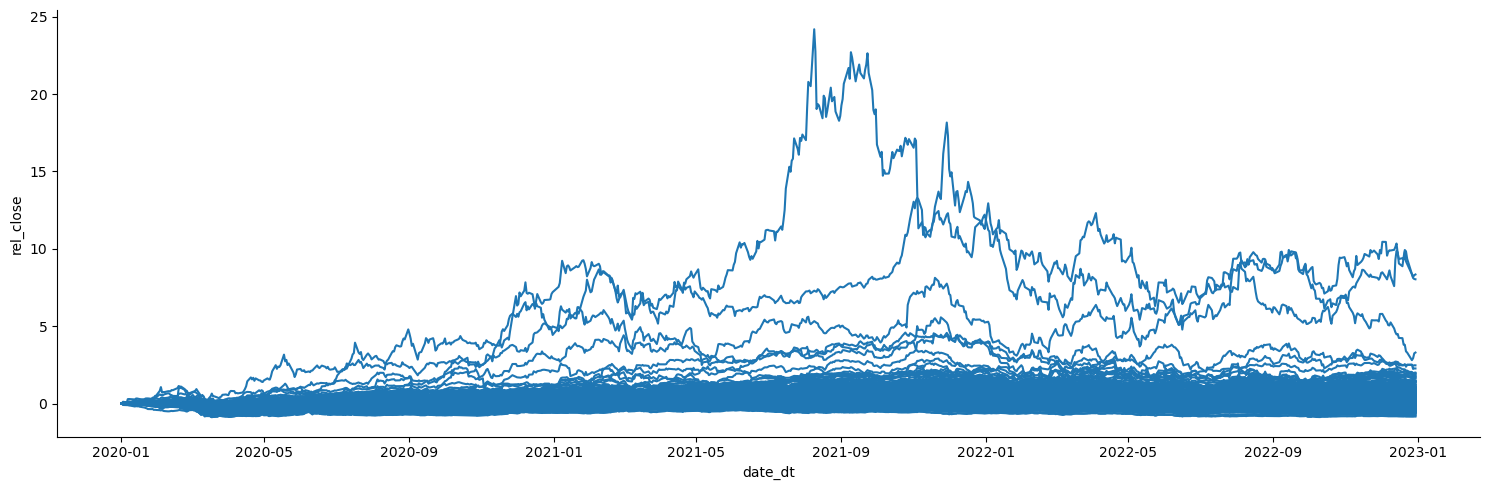

In [20]:
sns.relplot(data = stock_lf, x = 'date_dt', y = 'rel_close', units = 'symbol', estimator = None, 
           kind = 'line', aspect = 3)

plt.show()

We can see that few companies are still dominating the scale hence we will need to standardize the variables before modelling.

##### Checking the relative closing price for few stocks

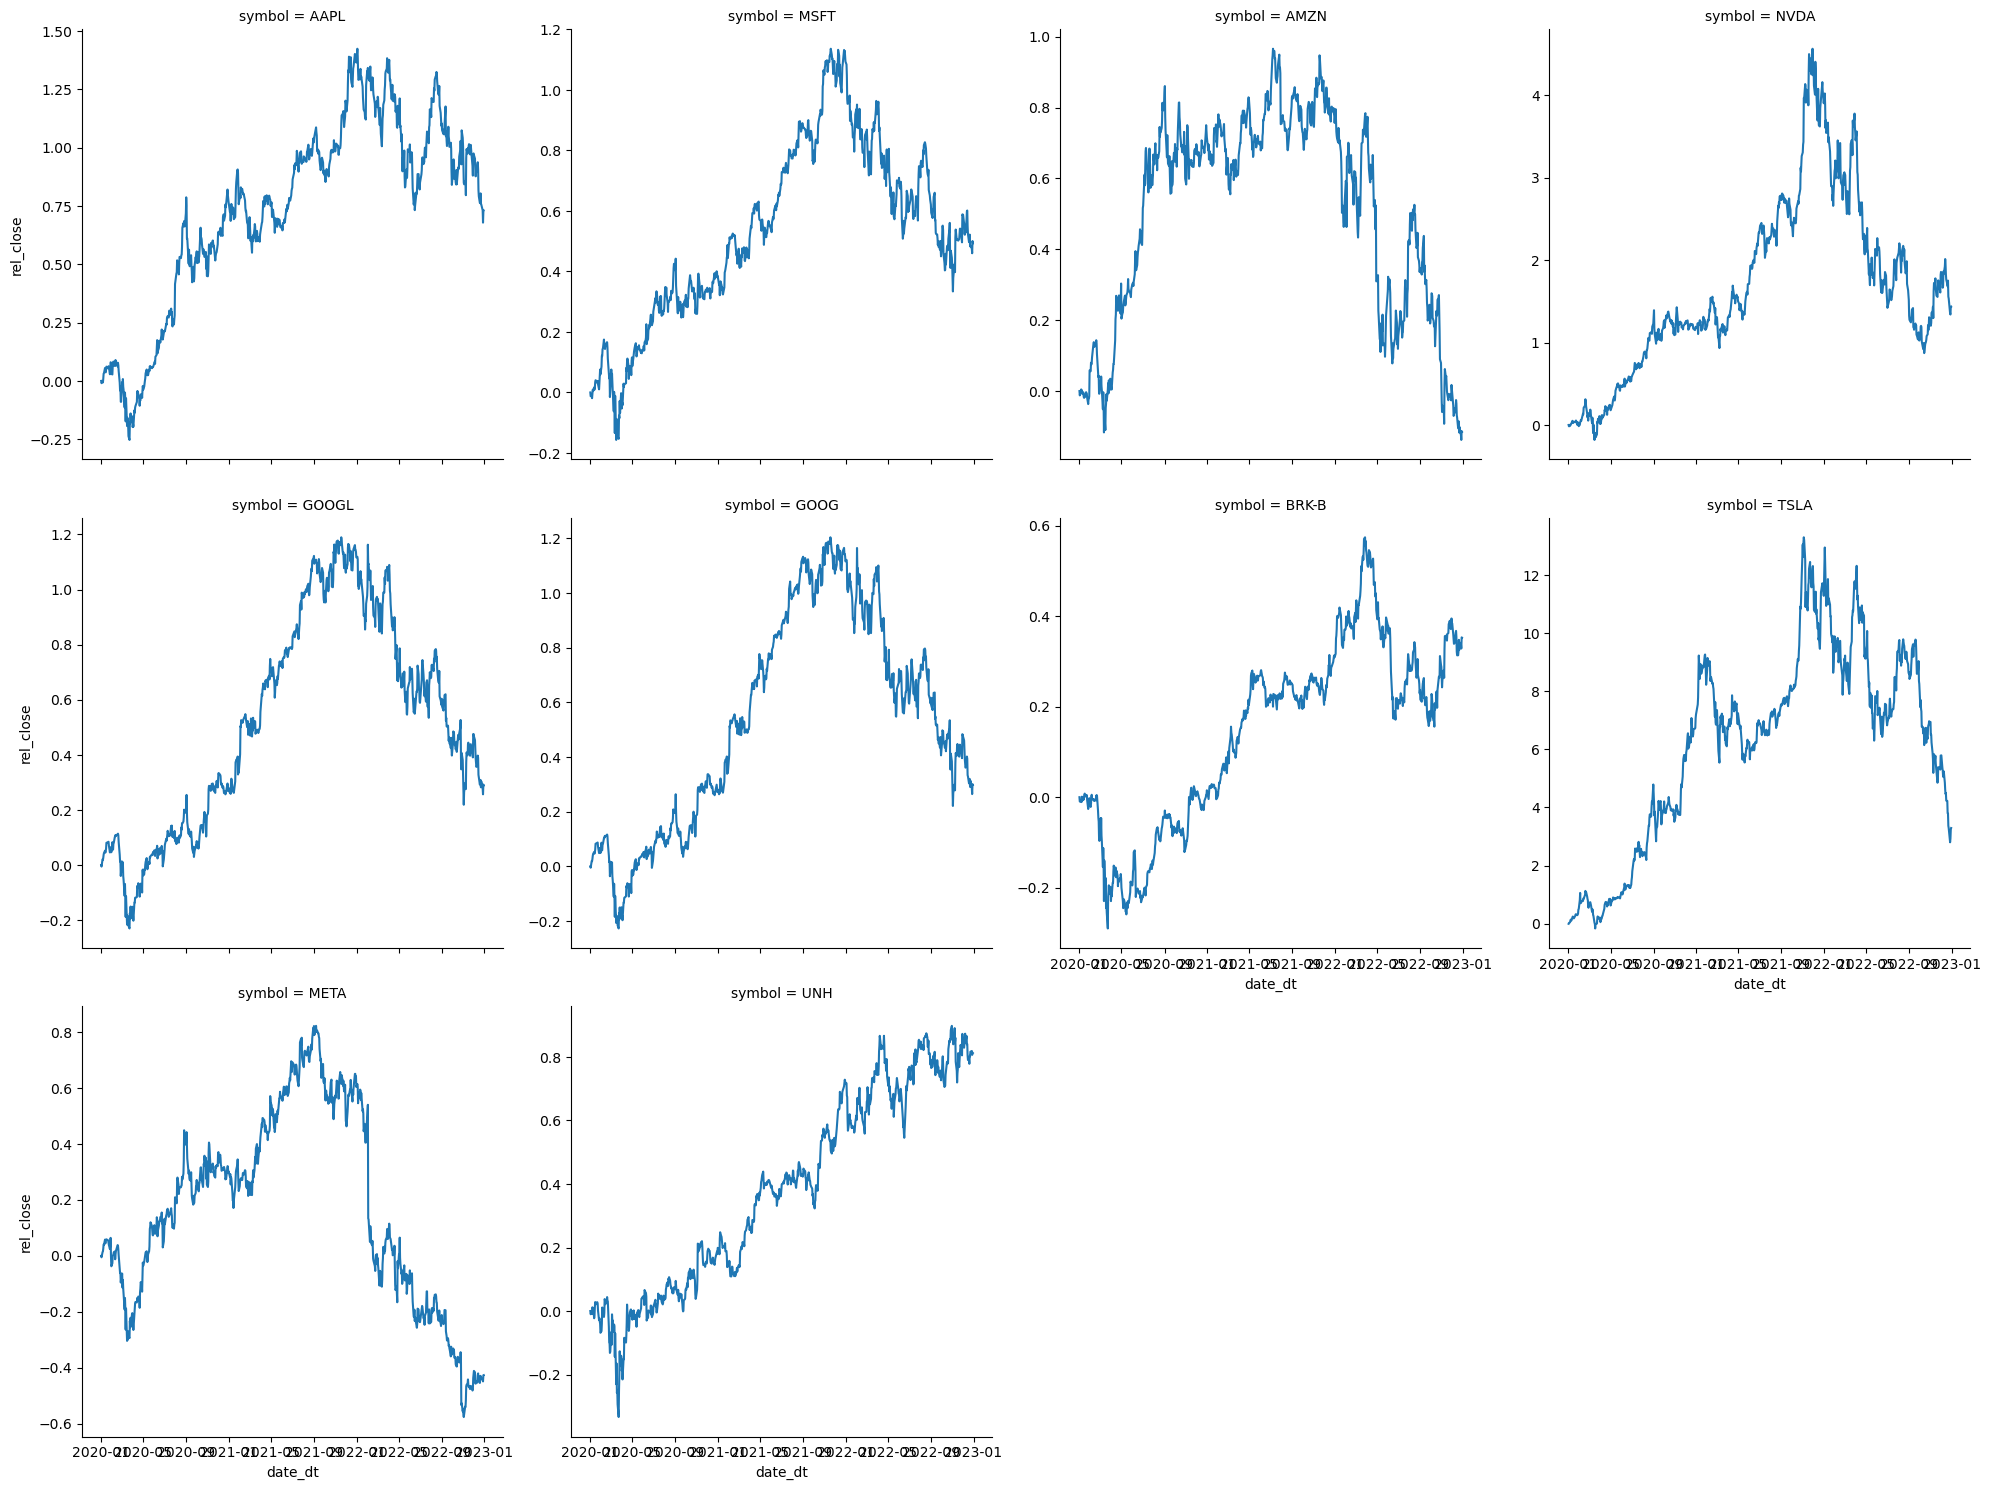

In [21]:
sns.relplot(data = stock_lf.loc[ stock_lf.symbol.isin(stock_lf.symbol.unique()[:10])],
           x = 'date_dt', y = 'rel_close', col = 'symbol', col_wrap=4,
           kind = 'line', units='symbol', estimator = None,
           facet_kws={'sharey':False})

plt.show()

**We can also color the above visualization by sector.**

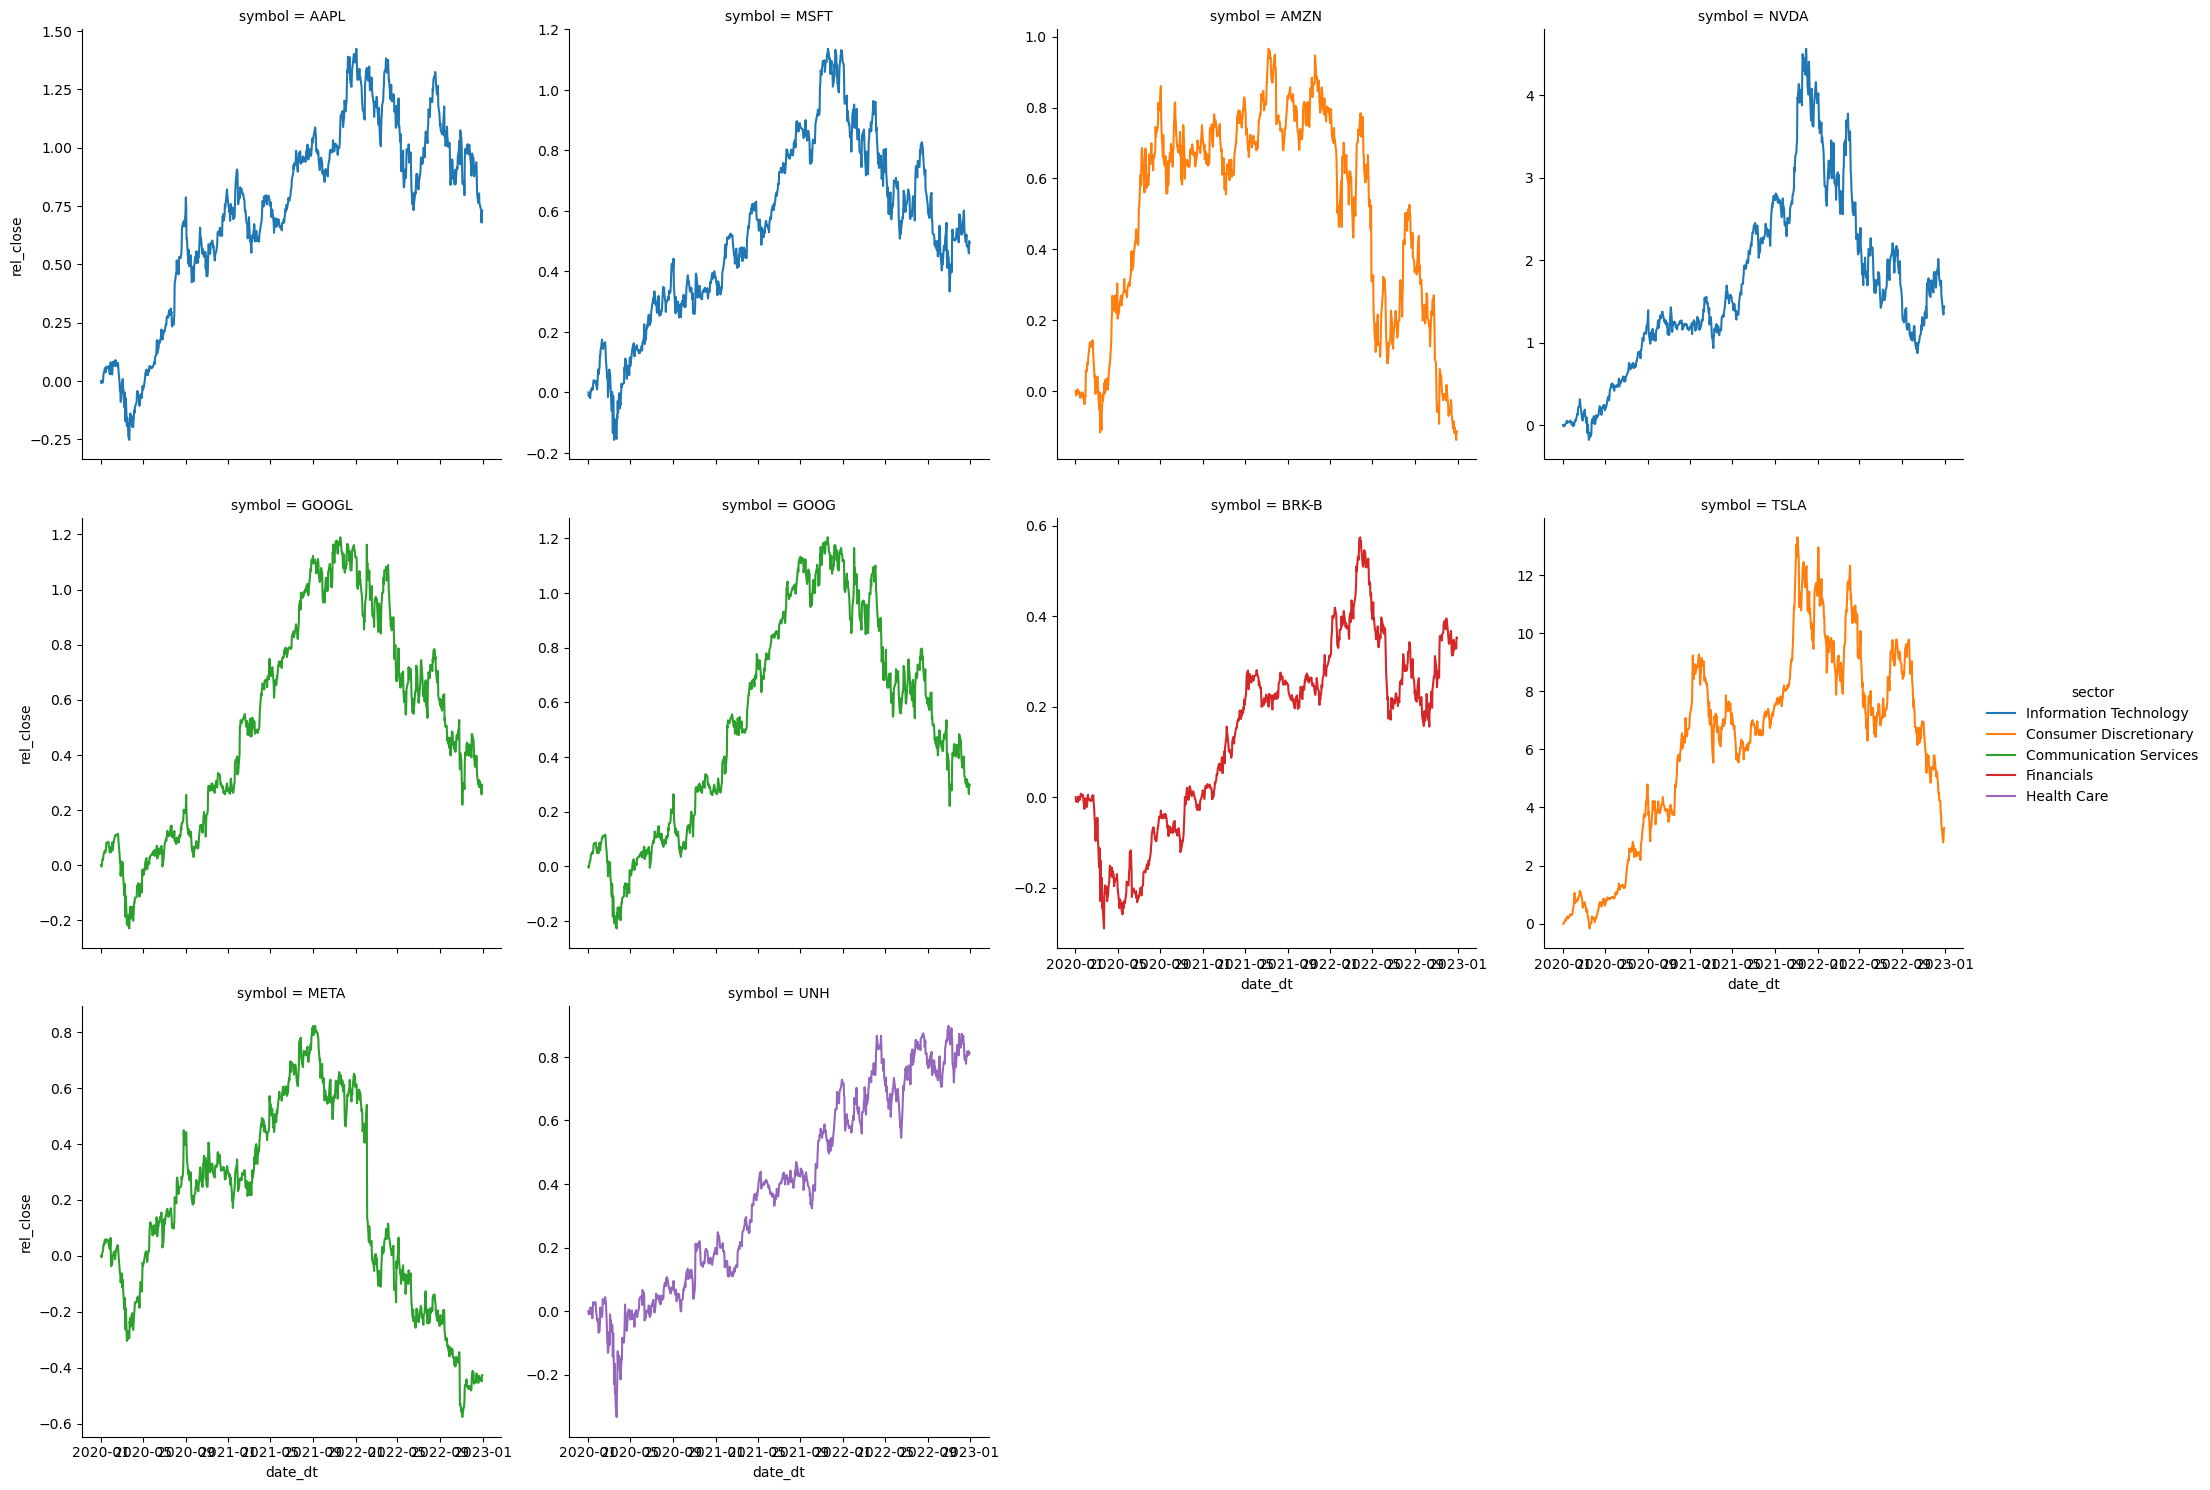

In [22]:
sns.relplot(data=stock_lf.loc[ stock_lf.symbol.isin(stock_lf.symbol.unique()[:10])],
           x='date_dt', y='rel_close',
           col='symbol', col_wrap=4, hue='sector',
           kind='line', estimator=None, units='symbol',
           facet_kws={'sharey':False})

plt.show()

##### Summarzing the relative closing price per day.

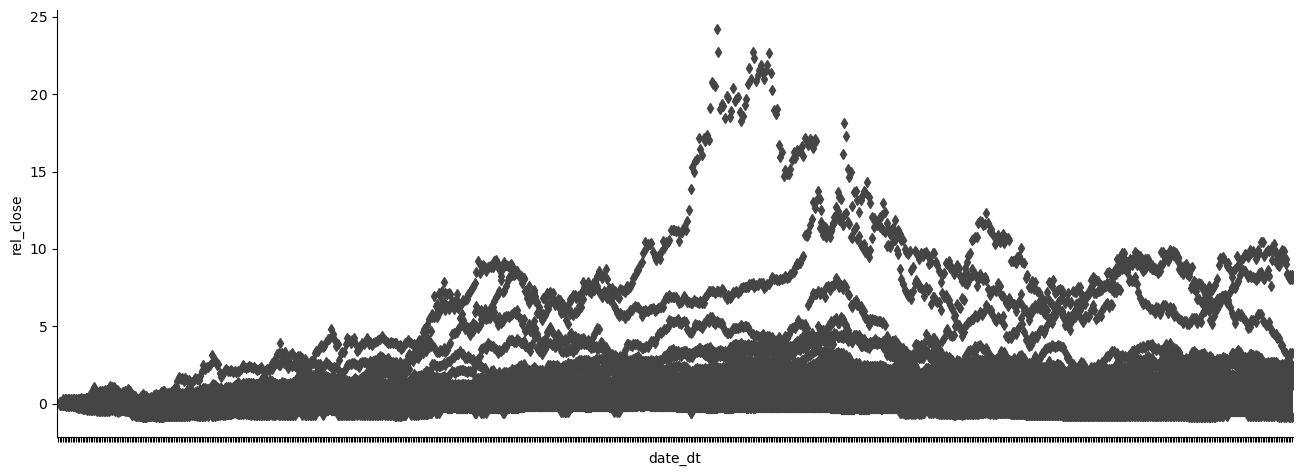

In [23]:
g = sns.catplot(data = stock_lf, x = 'date_dt', y = 'rel_close', aspect=3, kind='box')

g.set(xticklabels = [])

plt.show()

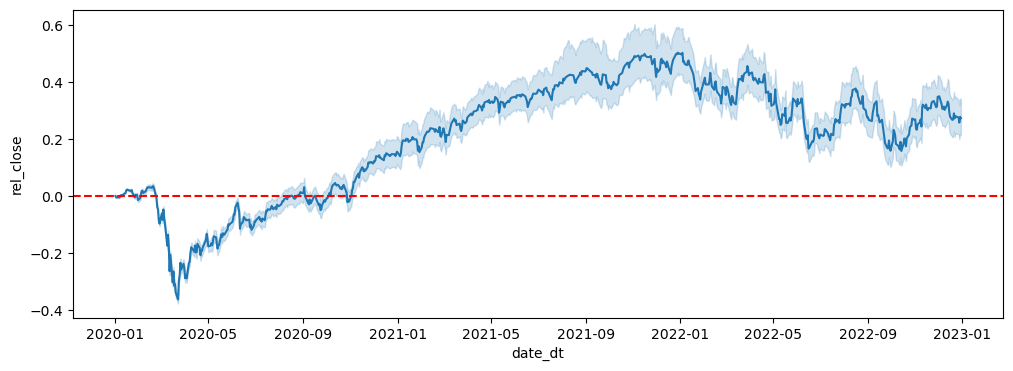

In [24]:
fig, ax = plt.subplots(figsize = (12, 4))

sns.lineplot(data=stock_lf, x = 'date_dt', y = 'rel_close', ax = ax)

ax.axhline(y = 0, color = 'red', linestyle = '--')

plt.show()

We can see that on average we would have gained some money if we would have invested in the above period.

### Converting the dataframe into wide format based on the relative closing price of the stocks.

In [25]:
wf = stock_lf.loc[:, ['symbol', 'sector', 'rel_close', 'day_number']].copy().\
     pivot(index = ['symbol', 'sector'], columns = 'day_number', values = 'rel_close').\
     reset_index()

In [26]:
wf

day_number,symbol,sector,day_001,day_002,day_003,day_004,day_005,day_006,day_007,day_008,...,day_747,day_748,day_749,day_750,day_751,day_752,day_753,day_754,day_755,day_756
0,A,Health Care,0.0,-0.016056,-0.013147,-0.010122,-0.000349,0.015358,0.019081,0.017568,...,0.737057,0.709715,0.721117,0.746248,0.733682,0.736242,0.739965,0.722978,0.757883,0.741129
1,AAL,Industrials,0.0,-0.049502,-0.060846,-0.064283,-0.042970,-0.039189,-0.060846,-0.058439,...,-0.559642,-0.570987,-0.569268,-0.552080,-0.568237,-0.563080,-0.569268,-0.576487,-0.563424,-0.562736
2,AAP,Consumer Discretionary,0.0,0.000063,-0.016373,-0.028041,-0.039207,-0.041026,-0.065241,-0.088765,...,-0.120758,-0.116116,-0.125651,-0.107396,-0.108713,-0.101186,-0.090270,-0.088514,-0.082178,-0.077661
3,AAPL,Information Technology,0.0,-0.009722,-0.001831,-0.006526,0.009456,0.030897,0.033228,0.055302,...,0.791377,0.762877,0.761944,0.803895,0.761012,0.756085,0.731713,0.678575,0.726119,0.730381
4,ABBV,Health Care,0.0,-0.009492,-0.001675,-0.007370,-0.000335,0.007370,-0.005472,-0.011502,...,0.792071,0.803350,0.793188,0.811390,0.823227,0.821329,0.820100,0.811614,0.815299,0.804690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,Consumer Discretionary,0.0,-0.003132,-0.003719,-0.001957,-0.000196,0.007732,-0.004698,-0.017911,...,0.266223,0.256533,0.258589,0.260448,0.260840,0.261623,0.271410,0.265636,0.272291,0.253597
496,ZBH,Health Care,0.0,-0.002614,-0.008378,-0.009249,0.002614,-0.004021,0.005295,-0.001206,...,-0.133060,-0.137340,-0.134096,-0.122705,-0.124707,-0.125397,-0.121324,-0.130230,-0.117527,-0.119806
497,ZBRA,Information Technology,0.0,-0.011924,-0.004361,-0.010303,-0.044378,-0.048777,-0.049664,-0.040750,...,-0.039438,-0.059543,-0.046269,-0.032029,-0.044879,-0.042139,-0.031412,-0.047465,-0.006213,-0.010535
498,ZION,Financials,0.0,-0.014111,-0.026125,-0.032037,-0.022502,-0.016018,-0.033753,-0.027079,...,-0.121472,-0.127765,-0.120328,-0.092868,-0.079329,-0.076087,-0.068650,-0.085240,-0.064073,-0.062548


In [27]:
(wf.day_001 == 0).sum()

500

##### Adding the outcome column by comparing the realative closing price of a stock at `day_756` that is last day of 2022 and comparing it to a date 3 months later that is `04-01-2023`.

**Getting the april 2023 data**

In [28]:
df_april = pd.read_csv('Data/sp500_stock_april_close_with_sector_wide_format.csv')

In [29]:
df_april.columns.values[2:] = ['days_from_' + str(d).zfill(2) for d in range(1, 62+1)]

In [30]:
df_april_use = df_use = df_april.loc[:, ['symbol', 'days_from_62']]

**Setting the relative closing price for April 2023 compared to Jan 1 2020**

In [31]:
temp_df = stock_wf.set_index('symbol').join(df_april_use.set_index('symbol'), on='symbol', how='left').reset_index()

In [32]:
temp_df['apr_rel_close'] = (temp_df.days_from_62 - temp_df.day_001) / temp_df.day_001

**Getting the final data to use ready and adding the april relative closing price**

In [33]:
wf['apr_rel_close'] = temp_df.apr_rel_close

In [34]:
wf['outcome'] = np.where(wf.apr_rel_close > wf.day_756, 'event', 'non-event')

##### Proportion of the `outcome` feature

In [35]:
wf.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

##### Checking the distribution of output variable

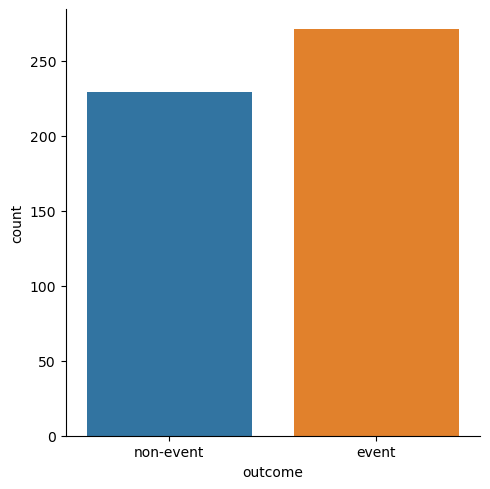

In [36]:
sns.catplot(data = wf, x = 'outcome', kind = 'count')

plt.show()

We can see that the `event` and `non-event` are evenly distributed.

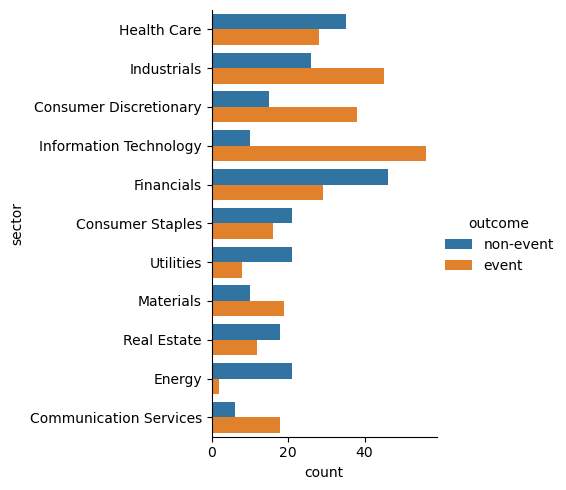

In [37]:
sns.catplot(data = wf, y = 'sector', hue='outcome', kind = 'count')

plt.show()

##### Looking at the distribution of the relative closing price for few day.

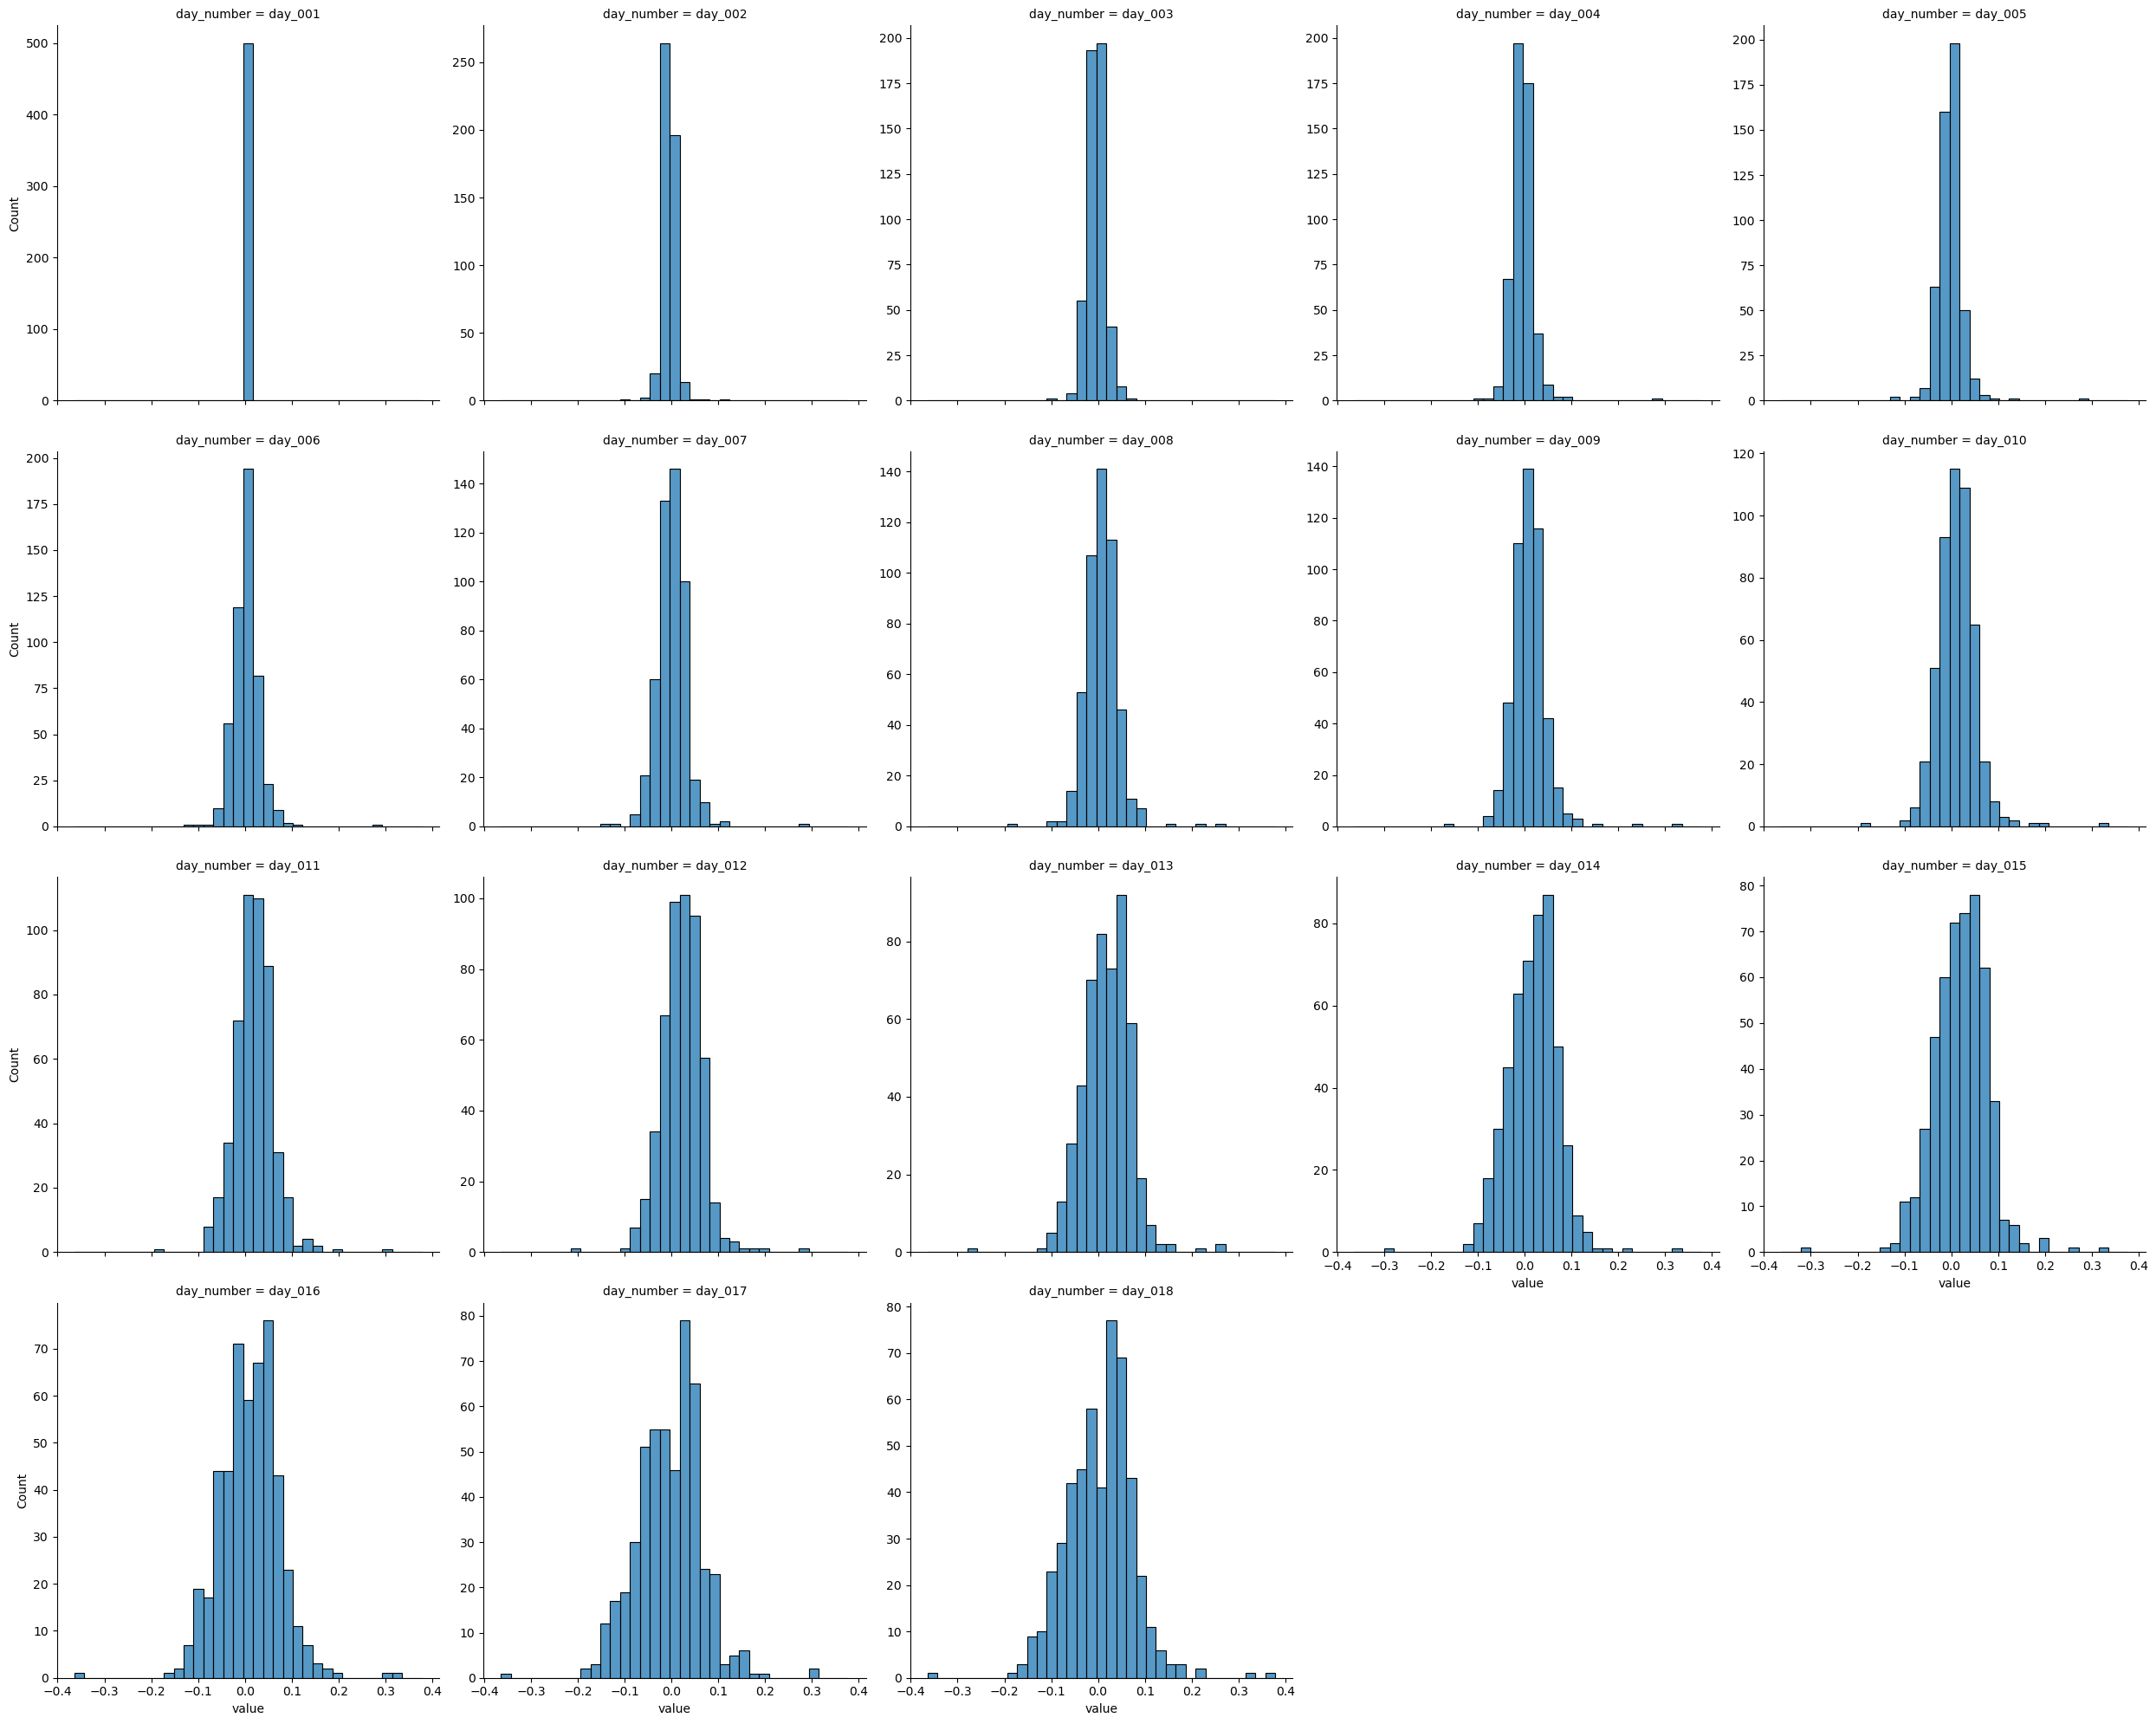

In [38]:
sns.displot(data = wf.iloc[:, 0:20].melt(id_vars=['symbol', 'sector']), 
            x = 'value', col='day_number', kind = 'hist',col_wrap=5, bins=35,
           facet_kws={'sharey':False})

plt.show()

##### Correlation between few trading days.

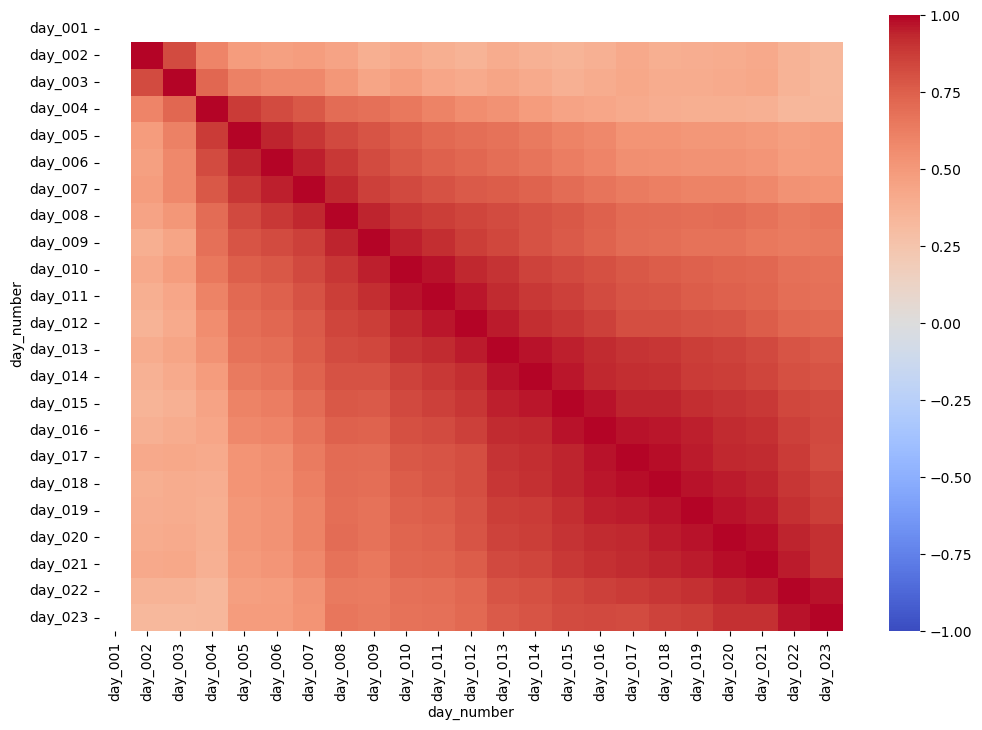

In [39]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(data = wf.iloc[:,2:25].corr(),
           vmin=-1, vmax=1, center=0,
           cmap='coolwarm',
           ax = ax)

plt.show()

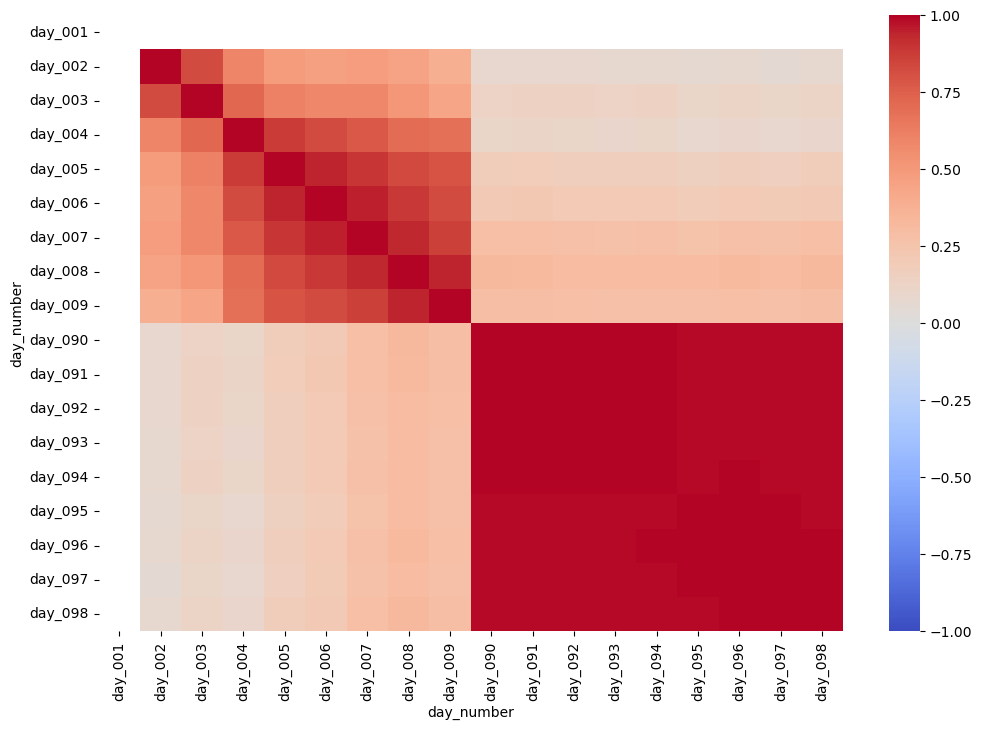

In [40]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(data = wf.iloc[:,[2,3,4,5,6,7,8,9,10,91,92,93,94,95,96,97,98,99]].corr(),
           vmin=-1, vmax=1, center=0,
           cmap='coolwarm',
           ax=ax)

plt.show()

We see that even thought the correlation decreases when comparing `day_002` with `day_091`, it is not exactly **zero**.

### PCA

In [41]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [42]:
wf_pca_df = wf.select_dtypes('number').copy()

In [43]:
wf_pca_df = wf_pca_df.drop(['day_001', 'apr_rel_close'], axis=1)

In [44]:
X_ready = StandardScaler().fit_transform( wf_pca_df )

In [45]:
pca_object = PCA().fit( X_ready )

In [46]:
pc_scores = pca_object.transform( X_ready )

In [47]:
pc_scores.shape

(500, 500)

In [48]:
pca_object.explained_variance_ratio_[:20]

array([7.50643603e-01, 1.04684556e-01, 4.73985413e-02, 2.82318154e-02,
       2.07343393e-02, 1.13842249e-02, 6.67731635e-03, 3.71409711e-03,
       3.11904495e-03, 2.76280597e-03, 2.38395172e-03, 2.19469717e-03,
       1.39506856e-03, 1.35675984e-03, 1.13078758e-03, 1.06127756e-03,
       7.59120889e-04, 6.81740937e-04, 6.12709182e-04, 5.68361211e-04])

### PCA Interpretation

##### Screeplot

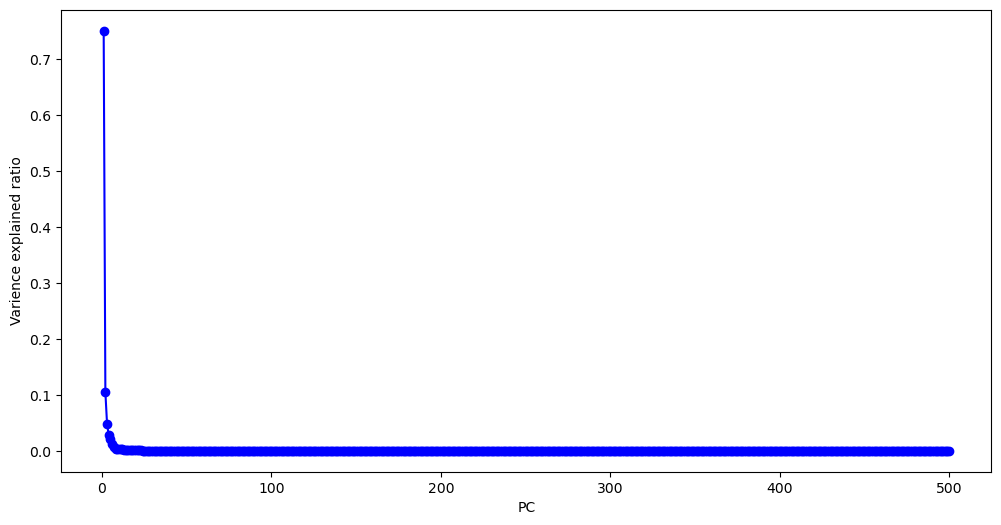

In [49]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(np.arange(len(pca_object.explained_variance_ratio_)) + 1, pca_object.explained_variance_ratio_, 'bo-')

ax.set_xlabel('PC')
ax.set_ylabel('Varience explained ratio')

plt.show()

We will focus on smaller number of PCs

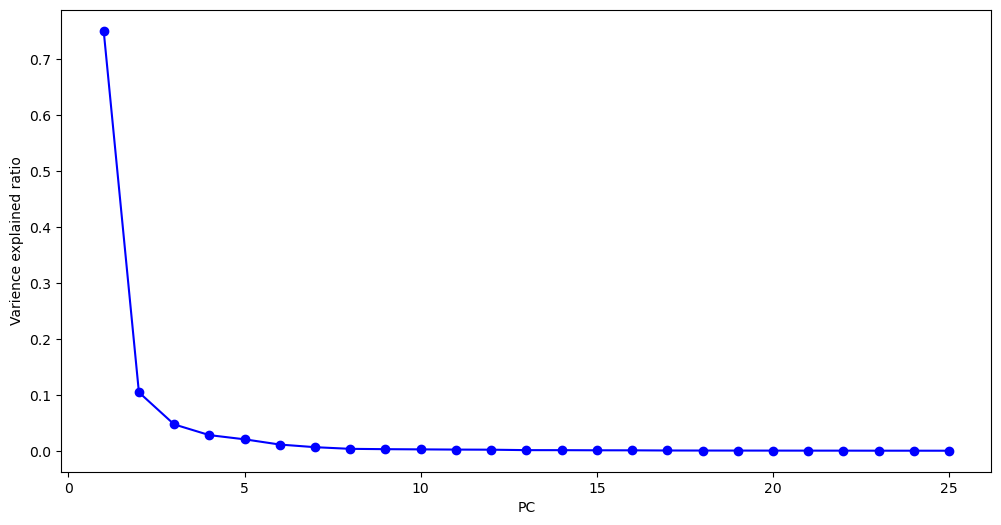

In [50]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(np.arange( len(pca_object.explained_variance_ratio_[:25])) +1, pca_object.explained_variance_ratio_[:25], 'bo-')

ax.set_xlabel('PC')
ax.set_ylabel('Varience explained ratio')

plt.show()

More than `70%` of the varience is explained by the first PC

Checking out the cumulative varience explained 

In [51]:
total_var_explained = pca_object.explained_variance_ratio_.cumsum()

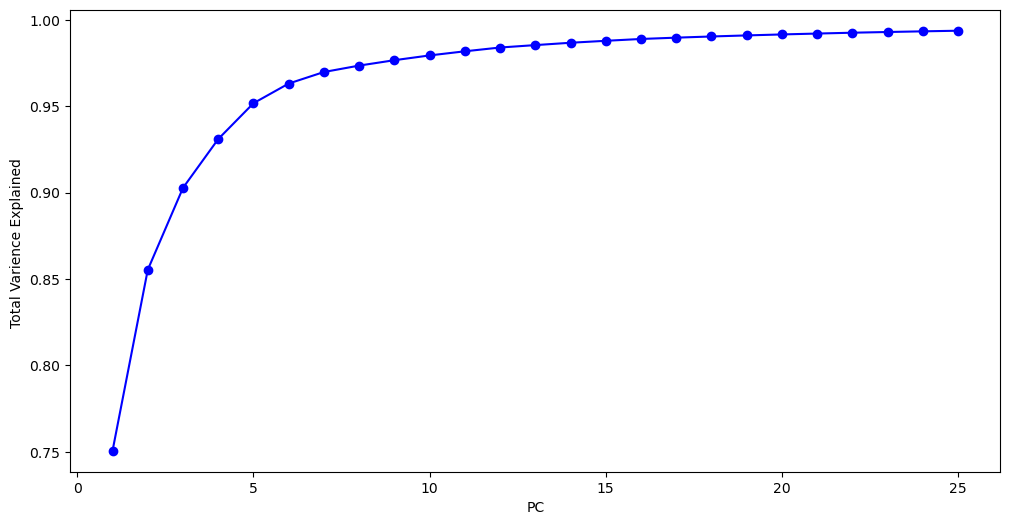

In [52]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(np.arange( len(total_var_explained[:25])) +1, total_var_explained[:25], 'bo-')

ax.set_xlabel('PC')
ax.set_ylabel("Total Varience Explained ")

plt.show()

In [53]:
pc_scores_df = pd.DataFrame(pc_scores, columns=['PC' + str(d+1).zfill(3) for d in range( pc_scores.shape[1])])

In [54]:
pc_scores_df

,PC001,PC002,PC003,PC004,PC005,PC006,PC007,PC008,PC009,PC010,...,PC491,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500
0,9.954248,-0.984928,0.549747,-2.241292,0.240735,1.520105,1.516756,-0.629022,1.013403,-0.066014,...,0.000765,-0.000899,-0.002022,0.001760,-0.003854,0.002119,-0.000825,-0.001083,-0.000011,5.117434e-16
1,-30.288549,10.433890,6.752080,1.348984,-0.255548,1.555198,-3.599943,2.749855,-1.789804,-0.368102,...,0.001770,0.003394,-0.002076,-0.006675,-0.001740,0.002272,-0.003094,0.001899,-0.000702,-6.574602e-14
2,-5.196052,4.342467,3.811006,-6.312480,-4.252736,-2.320305,-0.504153,1.795163,0.304192,-0.297415,...,0.002042,-0.000013,-0.000983,0.000422,-0.003420,-0.003377,0.001623,-0.001822,0.000627,-1.302777e-14
3,24.486469,-2.305703,-3.788882,1.025923,-4.075865,-2.010619,2.972707,1.891723,1.328478,-1.157063,...,-0.000059,-0.001380,-0.000236,-0.001223,0.001627,-0.000107,0.001833,-0.000882,0.000171,-2.213507e-15
4,5.197493,0.127169,-6.960450,-4.271592,-0.401790,-1.543399,-0.826063,0.278885,-0.915129,1.835767,...,0.001334,-0.000731,0.000279,0.001859,0.000570,-0.001165,-0.001219,0.000038,0.000910,-1.958503e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-5.463627,-0.282194,-0.438864,0.173278,0.920040,0.718970,0.305468,1.225796,-0.348121,-0.549031,...,-0.005543,0.003590,-0.001917,0.001425,-0.001013,0.002559,-0.001025,0.001735,-0.000600,-6.071532e-17
496,-12.192160,-3.348301,2.885294,1.587412,-1.175349,2.954762,-0.183866,0.952155,-0.605071,0.063783,...,-0.000328,0.001943,0.000945,0.003770,-0.001016,0.001949,0.000181,0.001410,0.000288,-1.804112e-15
497,9.841497,1.528695,11.466744,-2.311270,-2.556177,-1.380491,-2.099229,-1.690850,-1.316326,1.436984,...,-0.002572,-0.000326,0.000464,-0.001220,-0.000569,-0.001367,0.000301,0.000844,0.000068,1.534363e-15
498,-14.075810,11.228624,3.700510,-2.273366,-1.508452,-1.543273,-0.942615,-0.330225,-1.564727,0.158776,...,-0.000695,-0.001389,-0.002192,-0.001837,0.001786,0.001680,-0.000172,0.001021,-0.001032,-1.477768e-15


##### Correlation Structure of PC

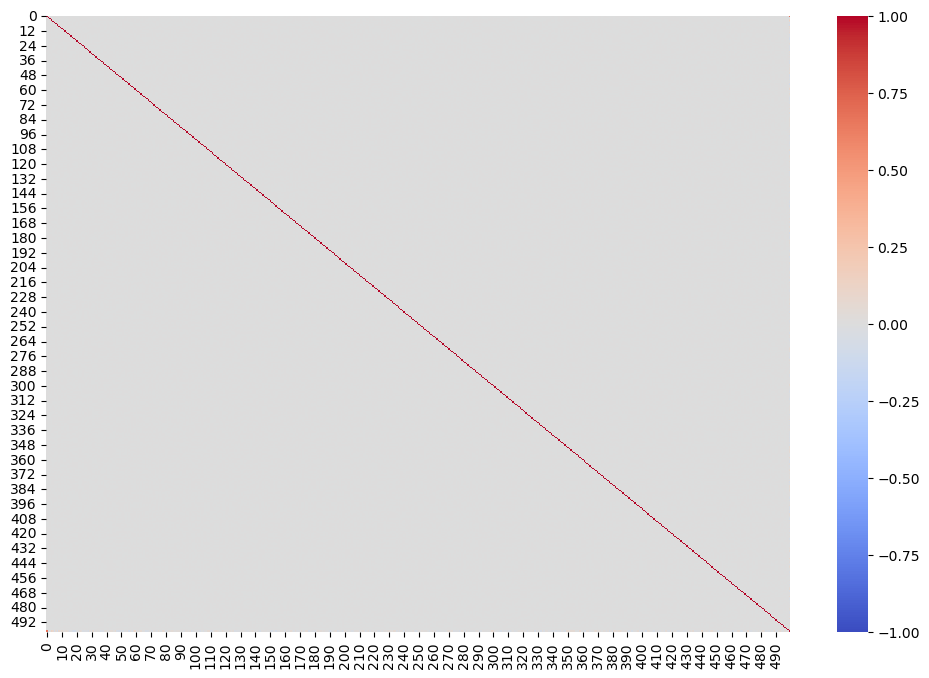

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pd.DataFrame(pc_scores).corr(),
           vmin=-1, vmax=1, center=0,
           cmap='coolwarm', 
           ax=ax)

plt.show()

##### Looking at the distributions of the PC

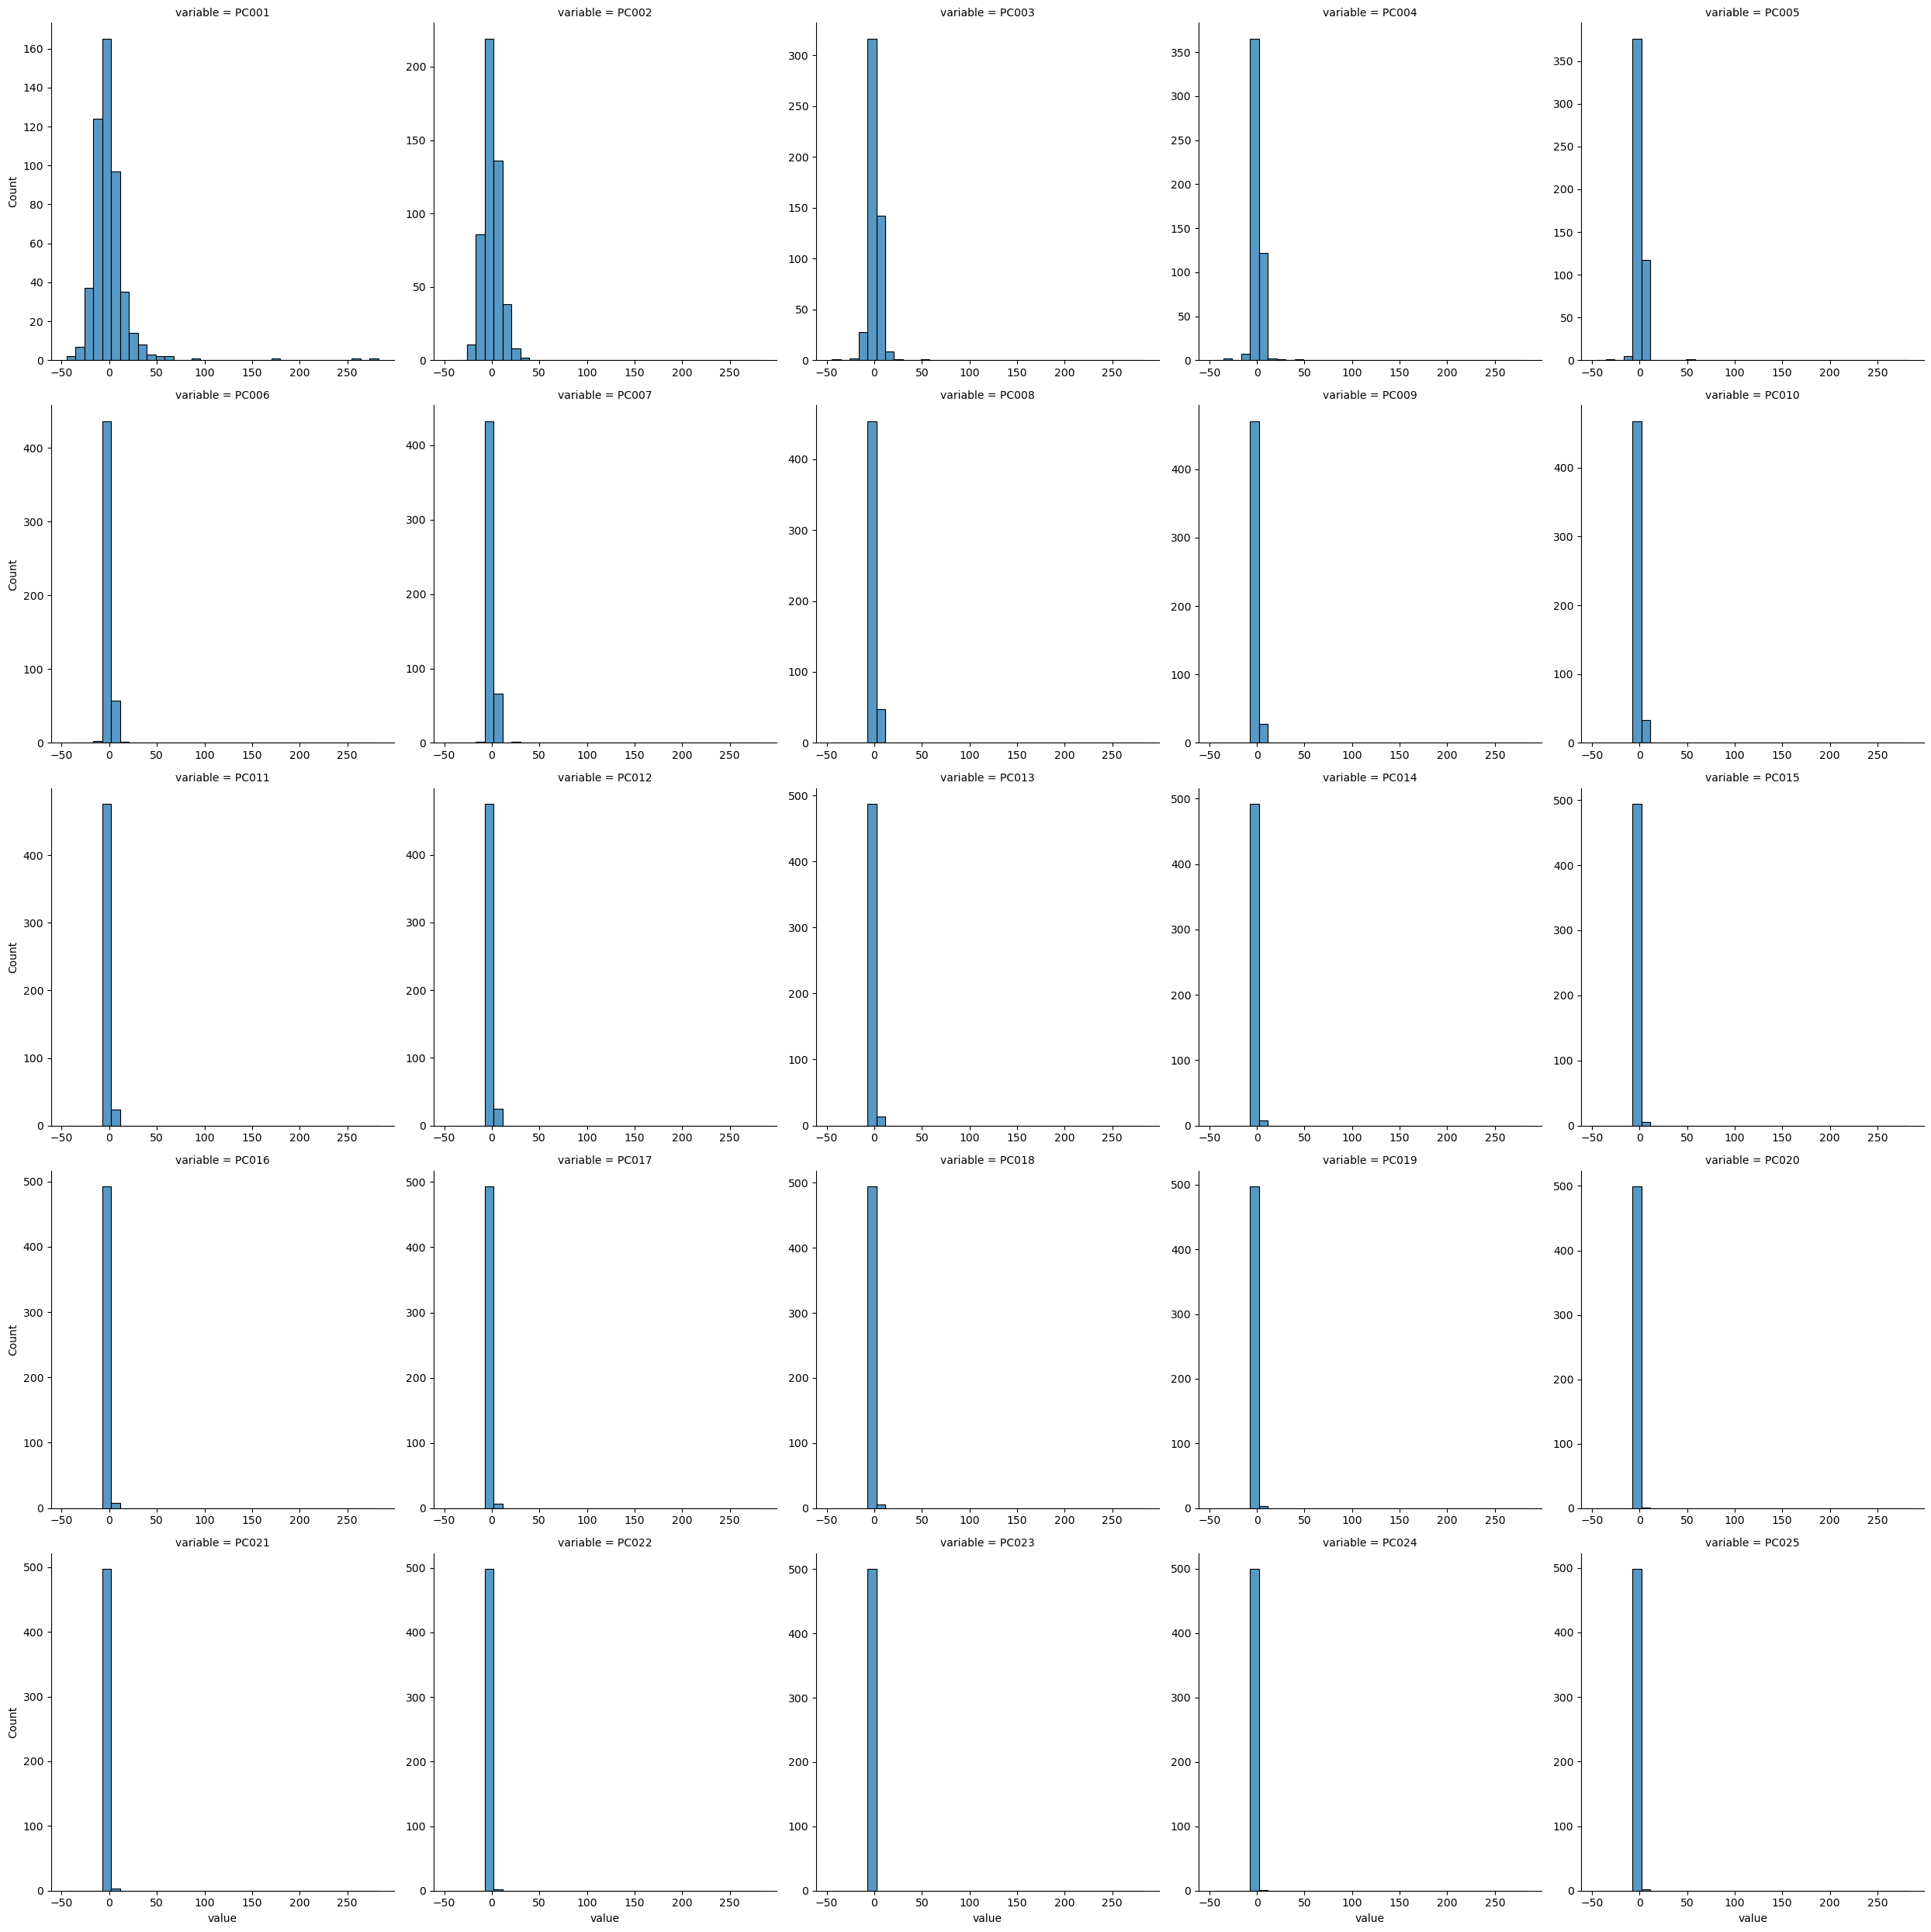

In [56]:
sns.displot(data = pc_scores_df.iloc[:, :25].melt(),
           x = 'value', col='variable', col_wrap=5,
           kind = 'hist', bins=35,
           facet_kws={'sharey':False, 'sharex':False})

plt.show()

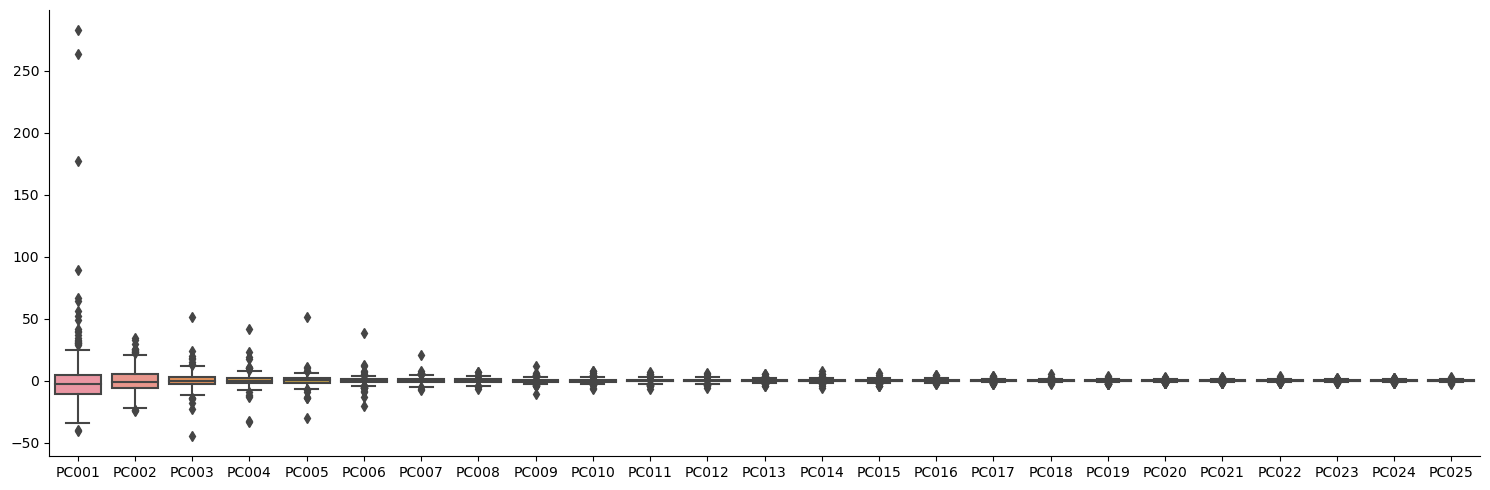

In [57]:
sns.catplot(data = pc_scores_df.iloc[:, :25], kind='box', aspect=3)

plt.show()

##### Adding the binary outcome to the PC scores dataframe

In [58]:
pc_scores_df['outcome'] = wf.outcome

In [59]:
pc_scores_df

,PC001,PC002,PC003,PC004,PC005,PC006,PC007,PC008,PC009,PC010,...,PC492,PC493,PC494,PC495,PC496,PC497,PC498,PC499,PC500,outcome
0,9.954248,-0.984928,0.549747,-2.241292,0.240735,1.520105,1.516756,-0.629022,1.013403,-0.066014,...,-0.000899,-0.002022,0.001760,-0.003854,0.002119,-0.000825,-0.001083,-0.000011,5.117434e-16,non-event
1,-30.288549,10.433890,6.752080,1.348984,-0.255548,1.555198,-3.599943,2.749855,-1.789804,-0.368102,...,0.003394,-0.002076,-0.006675,-0.001740,0.002272,-0.003094,0.001899,-0.000702,-6.574602e-14,event
2,-5.196052,4.342467,3.811006,-6.312480,-4.252736,-2.320305,-0.504153,1.795163,0.304192,-0.297415,...,-0.000013,-0.000983,0.000422,-0.003420,-0.003377,0.001623,-0.001822,0.000627,-1.302777e-14,non-event
3,24.486469,-2.305703,-3.788882,1.025923,-4.075865,-2.010619,2.972707,1.891723,1.328478,-1.157063,...,-0.001380,-0.000236,-0.001223,0.001627,-0.000107,0.001833,-0.000882,0.000171,-2.213507e-15,event
4,5.197493,0.127169,-6.960450,-4.271592,-0.401790,-1.543399,-0.826063,0.278885,-0.915129,1.835767,...,-0.000731,0.000279,0.001859,0.000570,-0.001165,-0.001219,0.000038,0.000910,-1.958503e-15,non-event
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-5.463627,-0.282194,-0.438864,0.173278,0.920040,0.718970,0.305468,1.225796,-0.348121,-0.549031,...,0.003590,-0.001917,0.001425,-0.001013,0.002559,-0.001025,0.001735,-0.000600,-6.071532e-17,event
496,-12.192160,-3.348301,2.885294,1.587412,-1.175349,2.954762,-0.183866,0.952155,-0.605071,0.063783,...,0.001943,0.000945,0.003770,-0.001016,0.001949,0.000181,0.001410,0.000288,-1.804112e-15,event
497,9.841497,1.528695,11.466744,-2.311270,-2.556177,-1.380491,-2.099229,-1.690850,-1.316326,1.436984,...,-0.000326,0.000464,-0.001220,-0.000569,-0.001367,0.000301,0.000844,0.000068,1.534363e-15,event
498,-14.075810,11.228624,3.700510,-2.273366,-1.508452,-1.543273,-0.942615,-0.330225,-1.564727,0.158776,...,-0.001389,-0.002192,-0.001837,0.001786,0.001680,-0.000172,0.001021,-0.001032,-1.477768e-15,non-event


In [60]:
num_pc = ['PC' + str(d+1).zfill(3) for d in range(15)]

In [61]:
num_pc

['PC001',
 'PC002',
 'PC003',
 'PC004',
 'PC005',
 'PC006',
 'PC007',
 'PC008',
 'PC009',
 'PC010',
 'PC011',
 'PC012',
 'PC013',
 'PC014',
 'PC015']

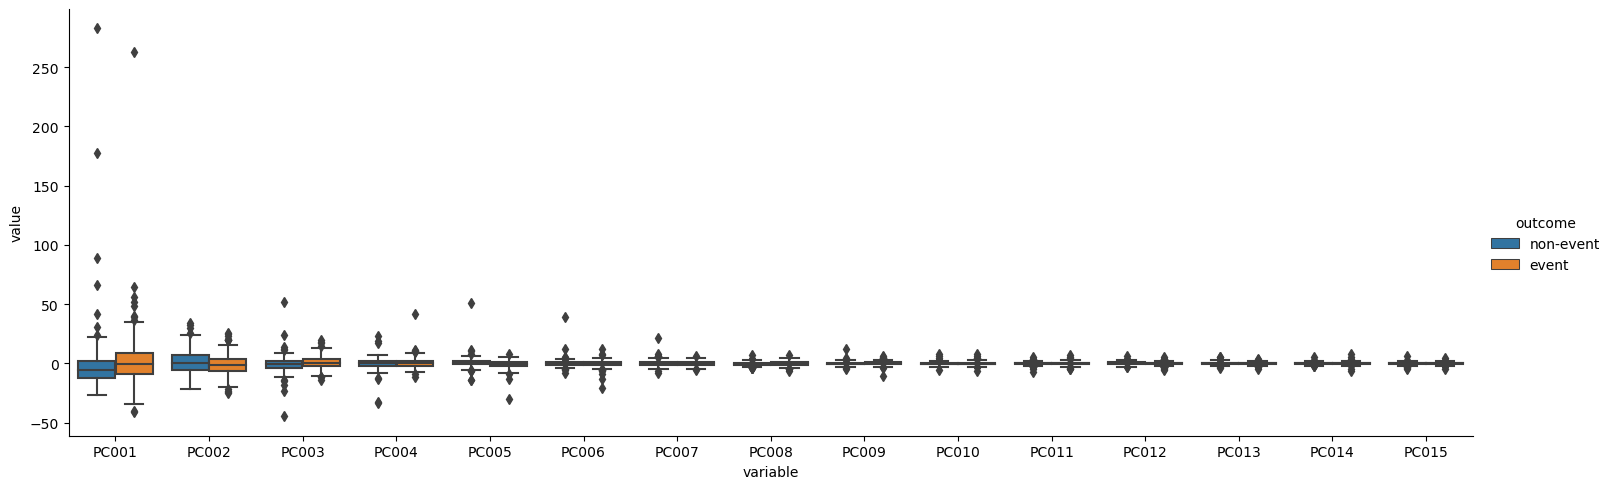

In [62]:
sns.catplot(data = pc_scores_df.loc[:, ['outcome'] + num_pc].melt(id_vars=['outcome']),
            x='variable', y='value', hue='outcome', 
            kind='box', aspect=3)

plt.show()

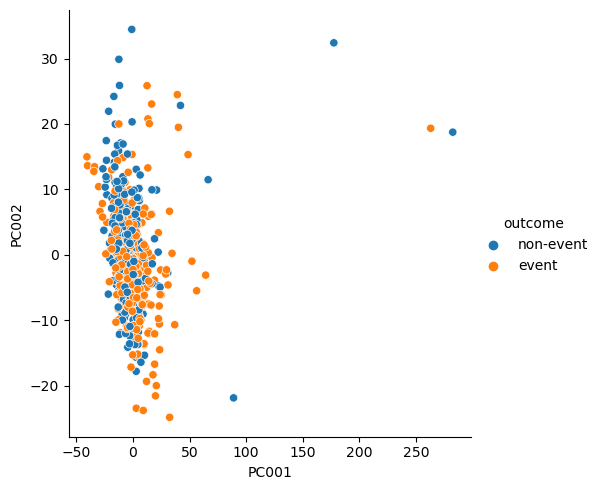

In [63]:
sns.relplot(data = pc_scores_df, x='PC001', y='PC002', hue='outcome')

plt.show()

##### Bi-plot

In [64]:
def my_biplot(scores_df, pca_object_use, pc_x, pc_y, x_names, marker_size_use=11, figsize_use=(9, 9)):
    # pc_x and pc_y are IDs for the PCs to show on the x and y axes of the plot
    # assumes that PC numbering starts at 1 NOT 0 !!!
    fig, ax = plt.subplots(figsize=figsize_use)
    
    x_pc_score = scores_df['PC' + str(pc_x).zfill(3)]
    y_pc_score = scores_df['PC' + str(pc_y).zfill(3)]
    
    load_mat = pca_object_use.components_[[pc_x-1, pc_y-1], :]
    
    # reference lines
    ax.axhline(y = 0, color='grey')
    ax.axvline(x = 0, color='grey')
    
    ax.scatter(x_pc_score, y_pc_score, s=marker_size_use)
    
    for i in range(load_mat.shape[1]):
        ax.arrow(0, 0,
                load_mat[0, i] * (x_pc_score.max() - x_pc_score.min()),
                load_mat[1, i] * (y_pc_score.max() - y_pc_score.min()),
                color='r')
        
        ax.text(load_mat[0, i] * 1.05 * (x_pc_score.max() - x_pc_score.min()),
                load_mat[1, i] * 1.05 * (y_pc_score.max() - y_pc_score.min()), 
                x_names[i], color = 'black', ha = 'center', va = 'center')
        
    # labels
    ax.set_xlabel('PC' + str(pc_x).zfill(2))
    ax.set_ylabel('PC' + str(pc_y).zfill(2))
    
    plt.show()

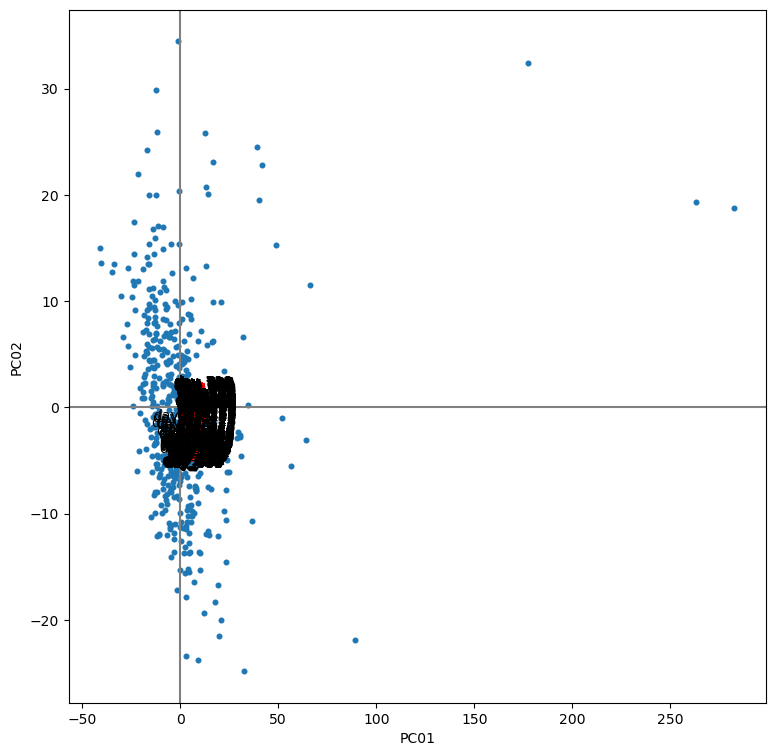

In [65]:
my_biplot( pc_scores_df, pca_object, 1, 2, wf_pca_df.columns.tolist() )

##### Contribution Plot

In [66]:
def calc_pca_contrib(load_mat):
    # square each element in the loadings matrix
    load_mat_sq = load_mat ** 2
    # sum the square loadings for each PC
    sum_load_squares = load_mat_sq.sum(axis=0)
    # divide the square loadings by the sum of the squared loadings per PC
    contrib_mat = load_mat_sq / sum_load_squares
    
    return(contrib_mat)

In [67]:
num_days = ['PC' + str(d+1).zfill(3) for d in range(50)]

In [68]:
contrib_mat = calc_pca_contrib( pca_object.components_ )

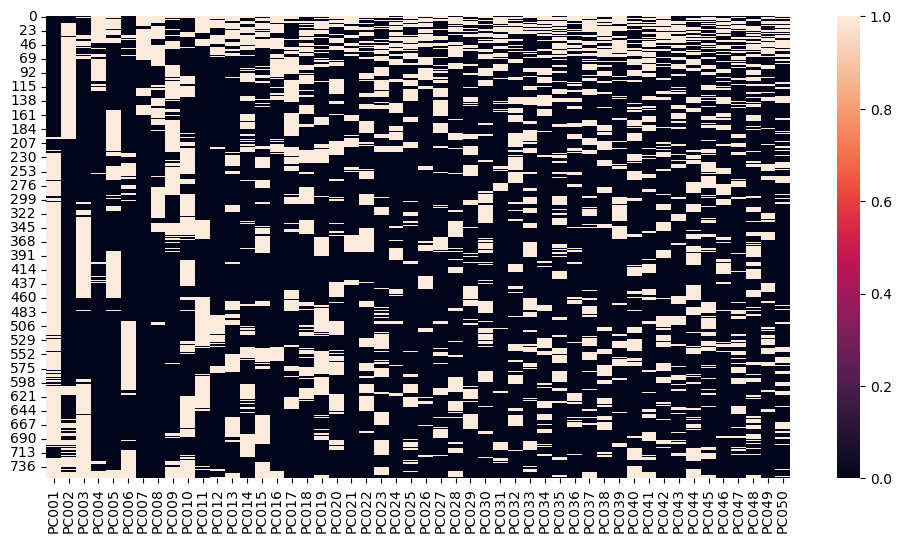

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap( data = ( np.transpose( calc_pca_contrib( pca_object.components_) ) > (1 / pc_scores.shape[1]) )[:,:50], 
            xticklabels=pc_scores_df.iloc[:, :len(num_days)].columns.tolist(),
            vmin=0, vmax=1)

plt.show()